In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
from interspeechmi.constants import MODELS_DIR
from interspeechmi.nlp.constants import VISUALS_DIR
from interspeechmi.nlp.unitask_code_prediction.constants import (
    ROBERTA_BASE_CHECKPOINT, 
    ROBERTA_LARGE_CHECKPOINT
)


In [2]:
per_split_results_df_path = os.path.join(
    VISUALS_DIR, "per_split_results.csv"
)
per_split_results_df = pd.read_csv(per_split_results_df_path)
per_split_results_df["window"] = per_split_results_df["window"].astype(str)
per_split_results_df["window"] = per_split_results_df["window"].apply(
    lambda x: "max" if x == "1000" else x
)

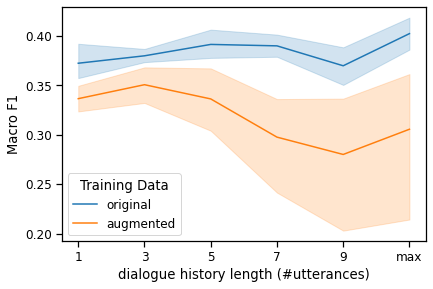

In [3]:
data_to_show = per_split_results_df.loc[
    (per_split_results_df["setup"].isin(["no", "5_aug"])) &
    (per_split_results_df["base_model"] == ROBERTA_BASE_CHECKPOINT)
].copy(deep=True)
data_to_show = data_to_show.rename(
    columns={
        "setup": "Training Data",
        "window": "dialogue history length (#utterances)",
        "f1": "Macro F1"
    }
)
data_to_show["Training Data"] = data_to_show["Training Data"].apply(
    lambda x: "original" if x == "no" else "augmented"
)

with sns.plotting_context("notebook", font_scale=1.1):
    aug_perf_plot = sns.lineplot(
        data=data_to_show, 
        x="dialogue history length (#utterances)",
        y="Macro F1",
        hue="Training Data"
    )
    for lh in aug_perf_plot.legend_.legendHandles: 
        lh.set_alpha(1)

    aug_perf_plot = aug_perf_plot.get_figure()
    aug_perf_plot.tight_layout(pad=0.5)
    plot_path = os.path.join(VISUALS_DIR, "aug_performances.pdf")
    aug_perf_plot.savefig(plot_path)

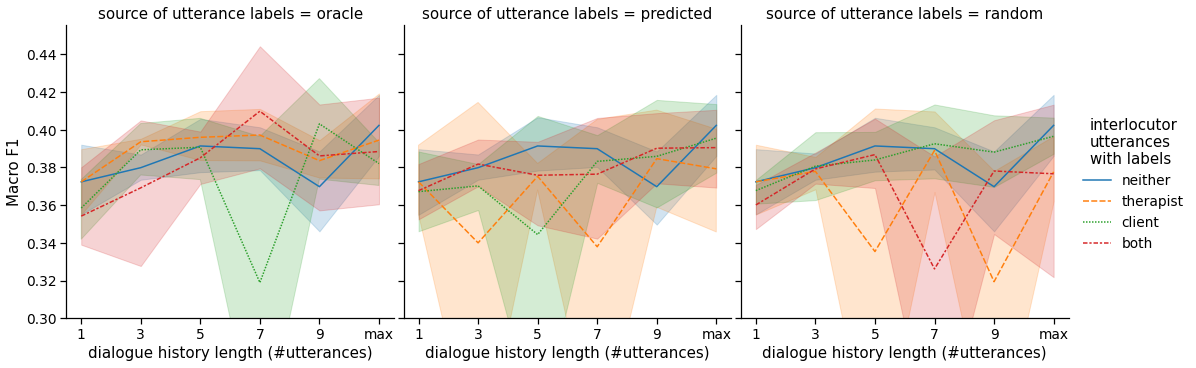

In [4]:
def rename_setup(setup: str):
    setup_ = setup.removesuffix("_predicted").removesuffix("_oracle").removesuffix("_random")
    if setup_ == "no":
        return "neither"
    elif setup_ == "therapist_and_client":
        return "both"
    else:
        return setup_

oracle_and_baseline = per_split_results_df.loc[
    (
        per_split_results_df["setup"].isin([
            "no", "therapist_oracle", 
            "client_oracle", 
            "therapist_and_client_oracle"
        ])
    ) &
    (per_split_results_df["base_model"] == ROBERTA_BASE_CHECKPOINT)
].copy(deep=True)
oracle_and_baseline["context_codes_type"] = "oracle"
oracle_and_baseline["setup"] = oracle_and_baseline["setup"].apply(rename_setup)

predicted_and_baseline = per_split_results_df.loc[
    (
        per_split_results_df["setup"].isin([
            "no", "therapist_predicted", 
            "client_predicted", 
            "therapist_and_client_predicted"
        ])
    ) &
    (per_split_results_df["base_model"] == ROBERTA_BASE_CHECKPOINT)
].copy(deep=True)
predicted_and_baseline["context_codes_type"] = "predicted"
predicted_and_baseline["setup"] = predicted_and_baseline["setup"].apply(rename_setup)

random_and_baseline = per_split_results_df.loc[
    (
        per_split_results_df["setup"].isin([
            "no", 
            "therapist_random", 
            "client_random", 
            "therapist_and_client_random"
        ])
    ) &
    (per_split_results_df["base_model"] == ROBERTA_BASE_CHECKPOINT)
].copy(deep=True)
random_and_baseline["context_codes_type"] = "random"
random_and_baseline["setup"] = random_and_baseline["setup"].apply(rename_setup)

scores_to_plot = pd.concat(
    [oracle_and_baseline, predicted_and_baseline, random_and_baseline], 
    ignore_index=True
).rename(
    columns={
        "setup": "interlocutor\nutterances\nwith labels",
        "window": "dialogue history length (#utterances)",
        "context_codes_type": "source of utterance labels",
        "f1": "Macro F1"
    }
)

with sns.plotting_context("notebook", font_scale=1.25):
    context_codes_perf_plot = sns.relplot(
        data=scores_to_plot, x="dialogue history length (#utterances)", y="Macro F1",
        col="source of utterance labels", hue="interlocutor\nutterances\nwith labels", 
        style="interlocutor\nutterances\nwith labels", kind="line"
    )
    context_codes_perf_plot.set(ylim=(0.3, None))
    context_codes_perf_plot.tight_layout(pad=0.2)
    plot_path = os.path.join(VISUALS_DIR, "using_utterance_labels_performances.pdf")
    context_codes_perf_plot.savefig(plot_path)

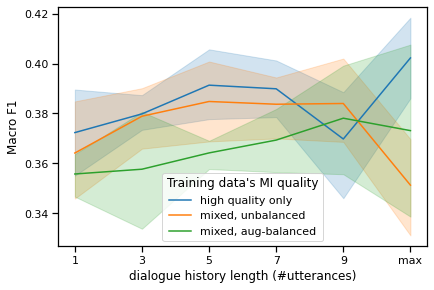

In [5]:
def rename_setup(setup: str):
    if setup == "no":
        return "high quality only"
    elif setup == "high_and_low_unbalanced":
        return "mixed, unbalanced"
    else:
        assert setup == "high_and_low_aug_balanced"
        return "mixed, aug-balanced"

data_to_show = per_split_results_df.loc[
    (per_split_results_df["setup"].isin(["no", "high_and_low_unbalanced", "high_and_low_aug_balanced"])) &
    (per_split_results_df["base_model"] == ROBERTA_BASE_CHECKPOINT)
].copy(deep=True)
data_to_show["setup"] = data_to_show["setup"].apply(rename_setup)
data_to_show = data_to_show.rename(
    columns={
        "window": "dialogue history length (#utterances)",
        "f1": "Macro F1",
        "setup": "Training data's MI quality"
    }
)

with sns.plotting_context("notebook", font_scale=1):
    aug_perf_plot = sns.lineplot(
        data=data_to_show, 
        x="dialogue history length (#utterances)",
        y="Macro F1",
        hue="Training data's MI quality"
    )
    sns.move_legend(aug_perf_plot, "lower center")
    for lh in aug_perf_plot.legend_.legendHandles: 
        lh.set_alpha(1)

    aug_perf_plot = aug_perf_plot.get_figure()
    aug_perf_plot.tight_layout(pad=0.5)
    plot_path = os.path.join(VISUALS_DIR, "mixed_mi_quality_performances.pdf")
    aug_perf_plot.savefig(plot_path)

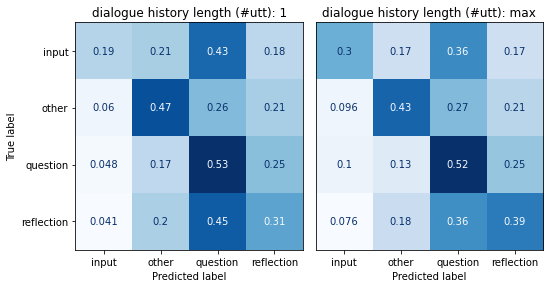

In [6]:
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7.68, 3.84))

for window, axis in zip([1, 1000], axes):
    results_path = os.path.join(
        MODELS_DIR,
        "unitask_code_prediction",
        "next_turn_code_forecast",
        f"anno_mi.high_quality.contexts.no_codes_in_context.context_window_{window}.clean_separation_of_dialogues.response_from_therapist_only.5_fold_splits",
        "roberta-base.joint_model.max_seq_len_512.seed_42.bs_8.lr_2e-05.warmup_ratio_0.0.weight_decay_0.01.grad_acc_1.epochs_10",
        "cross_validation_test_results.csv"
    )
    results = pd.read_csv(results_path)
    display = ConfusionMatrixDisplay.from_predictions(
        y_true=results["ground_truth_code"],
        y_pred=results["predicted_code"],
        normalize="true",
        cmap='Blues',
        ax=axis,
        colorbar=False
    )
    if window == 1000:
        window_str = r"max"
    else:
        window_str = r"{}".format(window)

    axis.title.set_text(r"dialogue history length (#utt): " + window_str)

axes[1].set_ylabel("")
axes[1].get_yaxis().set_ticks([])

plot_path = os.path.join(VISUALS_DIR, "confusion_matrices.pdf")
display.figure_.tight_layout(pad=0.8)
display.figure_.savefig(plot_path)